In [1]:
import pandas as pd

df = pd.read_csv('housing.data.txt', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RМ', 'AGE', 'DIS', 'RAD',
              'ТАХ', 'PTRATIO', 'В', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RМ,AGE,DIS,RAD,ТАХ,PTRATIO,В,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


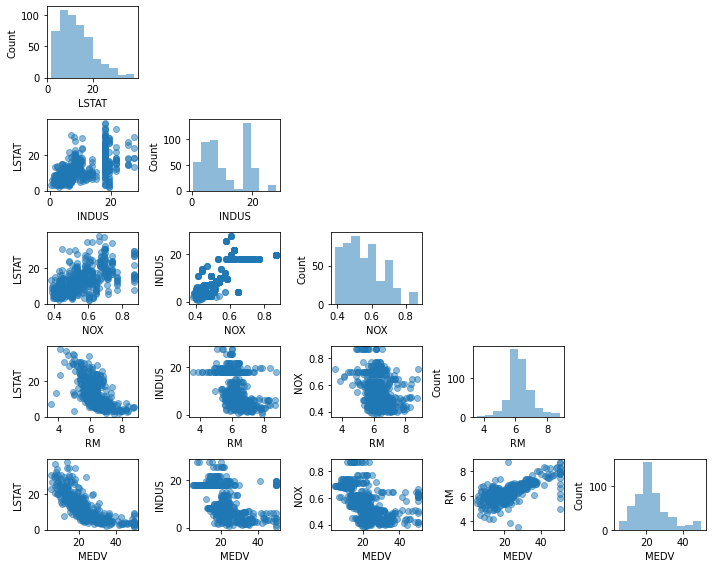

In [2]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

cols = ['LSTAT', 'INDUS', 'NOX', 'RМ', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10, 8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

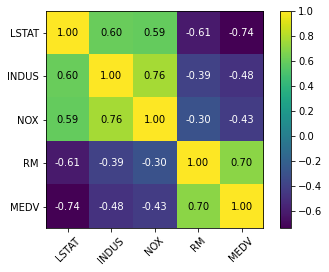

In [3]:
from mlxtend.plotting import heatmap
import numpy as np

cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)
plt.show()

In [4]:
from linearregression.linearrergressiongd import LinearRegressionGD

X = df[['RМ']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

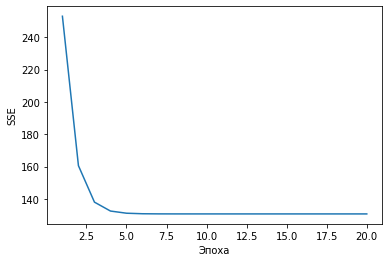

In [5]:
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Эпоха')
plt.show()

In [6]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

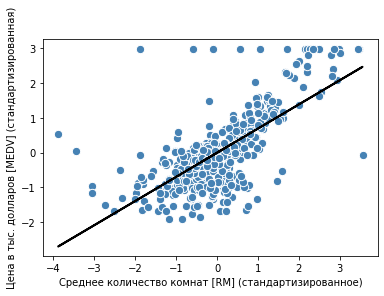

In [7]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Cpeднee количество комнат [RМ] (стандартизированное)')
plt.ylabel('Цена в тыс. долларов [MEDV] (стандартизированная)')
plt.show()

In [8]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Цена в тыс. долларов: %.3f" % sc_y.inverse_transform(price_std.reshape(-1, 1)))

Цена в тыс. долларов: 10.840


In [9]:
print('Наклон: %.3f' % lr.w_[1])
print('Точка пересечения: %.3f' % lr.w_[0])

Наклон: 0.695
Точка пересечения: -0.000


In [10]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Наклон: %.3f' % slr.coef_[0])
print('Точка пересечения: %.3f' % slr.intercept_)

Наклон: 9.102
Точка пересечения: -34.671


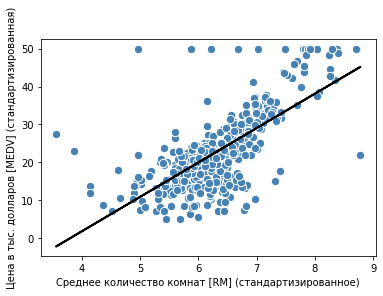

In [11]:
lin_regplot(X, y, slr)
plt.xlabel('Среднее количество комнат [RМ] (стандартизированное)')
plt.ylabel('Цeнa в тыс. долларов [MEDV] (стандартизированная)')
plt.show()

In [12]:
# добавление вектора-столбца единиц
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))
print('Наклон: %.3f' % w[1])
print('Точка пересечения: %.3f' % w[0])

Наклон: 9.102
Точка пересечения: -34.671


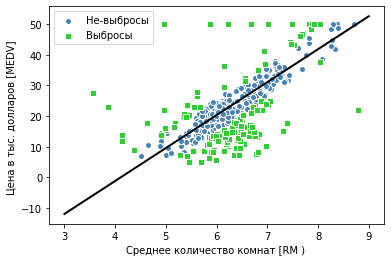

In [13]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_error',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Не-выбросы')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Выбросы')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Среднее количество комнат [RМ ) ')
plt.ylabel('Цена в тыс. долларов [MEDV] ')
plt.legend(loc='upper left')
plt.show()

In [14]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


In [15]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

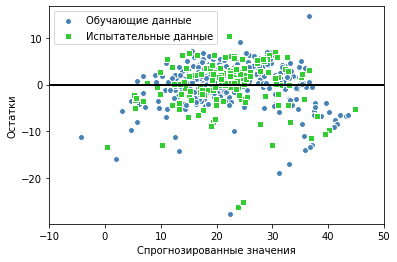

In [16]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white',
            label='Обучающие данные')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white',
            label='Испытательные данные')
plt.xlabel('Спрогнозированные значения')
plt.ylabel('Остатки')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

print('MSE при обучении: %.3f, при испытании: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

MSE при обучении: 19.958, при испытании: 27.196


In [18]:
from sklearn.metrics import r2_score

print('R^2 при обучении: %.3f, при испытании: %.3f' %
      (r2_score(y_train, y_train_pred),
       r2_score(y_test, y_test_pred)))

R^2 при обучении: 0.765, при испытании: 0.673


In [19]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [23]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

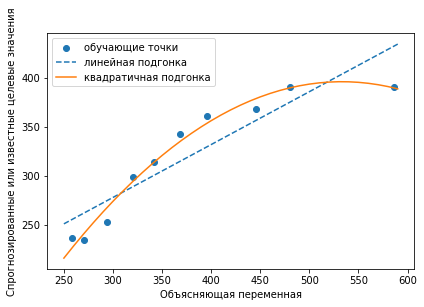

In [24]:
plt.scatter(X, y, label='обучающие точки')
plt.plot(X_fit, y_lin_fit, label='линейная подгонка', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='квадратичная подгонка')
plt.xlabel('Объясняющая переменная')
plt.ylabel('Спрогнозированные или известные целевые значения')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [25]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('MSE при обучении линейной модели: %.3f, квадратичной модели: %.3f' % (
    mean_squared_error(y, y_lin_pred),
    mean_squared_error(y, y_quad_pred)))

MSE при обучении линейной модели: 569.780, квадратичной модели: 61.330


In [26]:
print('R^2 при обучении линейной модели: %.3f, квадратичной модели: %.3f' % (
    r2_score(y, y_lin_pred),
    r2_score(y, y_quad_pred)))

R^2 при обучении линейной модели: 0.832, квадратичной модели: 0.982


In [30]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()
# создать квадратичные признаки
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
# выполнить подгонку к признакам
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

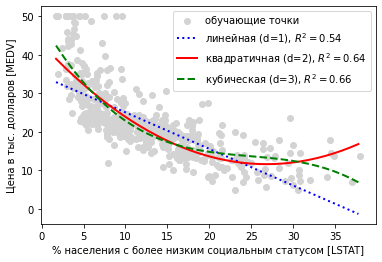

In [34]:
# вывести результаты
plt.scatter(X, y, label='обучающие точки', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='линейная (d=1), $R^2=%.2f$' % linear_r2, color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='квадратичная (d=2), $R^2=%.2f$' % quadratic_r2, color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='кубическая (d=З), $R^2=%.2f$' % cubic_r2, color='green', lw=2, linestyle='--')
plt.xlabel('% населения с более низким социальным статусом [LSTAT]')
plt.ylabel('Цена в тыс. долларов [MEDV]')
plt.legend(loc='upper right')
plt.show()

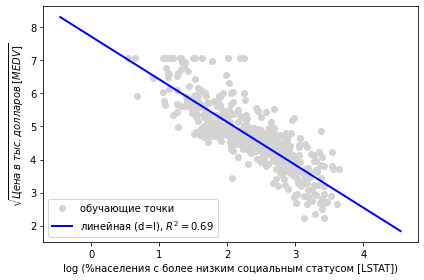

In [37]:
# трансформировать признаки
X_log = np.log(X)
y_sqrt = np.sqrt(y)
# выполнить подгонку к признакам
X_fit = np.arange(X_log.min() - 1,
                  X_log.max() + 1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))
# вывести результаты
plt.scatter(X_log, y_sqrt, label='обучающие точки', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='линейная (d=l), $R^2=%.2f$' % linear_r2, color='blue', lw=2)
plt.xlabel('log (%населения с более низким социальным статусом [LSTAT])')
plt.ylabel('$\sqrt{Цeнa \; в \; тыс. долларов \; [MEDV]}$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

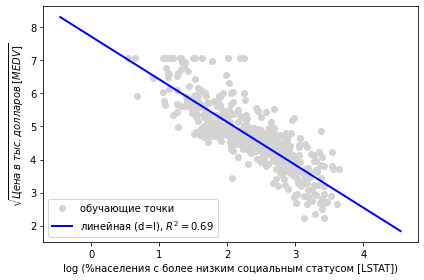

In [39]:
# трансформировать признаки
X_log = np.log(X)
y_sqrt = np.sqrt(y)
# выполнить подгонку к признакам
X_fit = np.arange(X_log.min() - 1, X_log.max() + 1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))
# вывести результаты
plt.scatter(X_log, y_sqrt, label='обучающие точки', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='линейная (d=l), $R^2=%.2f$' % linear_r2, color='blue', lw=2)
plt.xlabel('log (%населения с более низким социальным статусом [LSTAT])')
plt.ylabel('$\sqrt{Цeнa \; в \; тыс. долларов \; [MEDV]}$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

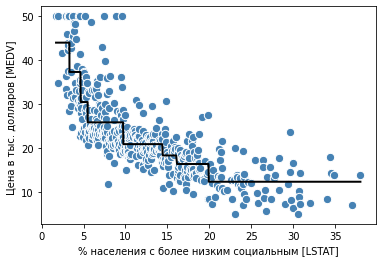

In [40]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% населения с более низким социальным [LSTAT]')
plt.ylabel('Цена в тыс. долларов [MEDV]')
plt.show()

In [42]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE при обучении: %.3f, при испытании: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 при обучении: %.3f, при испытании: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE при обучении: 1.644, при испытании: 11.085
R^2 при обучении: 0.979, при испытании: 0.877


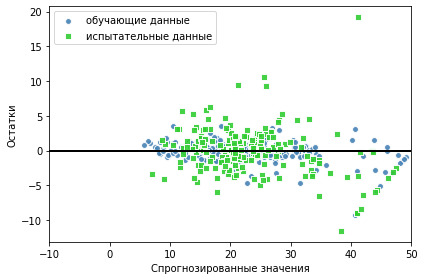

In [44]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', edgecolor='white', marker='o', s=35, alpha=0.9,
            label='обучающие данные')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', edgecolor='white', marker='s', s=35, alpha=0.9,
            label='испытательные данные')
plt.xlabel('Спрогнозированные значения')
plt.ylabel('Остатки')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()